In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
df_05 = pd.read_csv('data/merged-05-2019.csv')
df_06 = pd.read_csv('data/merged-06-2019.csv')
df_07 = pd.read_csv('data/merged-07-2019.csv')
df_08 = pd.read_csv('data/merged-08-2019.csv')
df_09 = pd.read_csv('data/merged-09-2019.csv')
df_10 = pd.read_csv('data/merged-10-2019.csv')
df_11 = pd.read_csv('data/merged-11-2019.csv')
df_12 = pd.read_csv('data/merged-12-2019.csv')

In [3]:
df = pd.concat([df_05, df_06, df_07, df_08], ignore_index=True)
#, df_08, df_09, df_10, df_11, df_12

In [4]:
%reset_selective -f "^df_"

In [5]:
df = df[['carrier_code', 'day', 'weekday', 'month', 'origin_airport', 
          'destination_airport', 
          'scheduled_elapsed_time', 'scheduled_departure_dt', 'scheduled_arrival_dt',
          'STATION_x', 'HourlyDryBulbTemperature_x', 'HourlyPrecipitation_x', 'HourlyVisibility_x', 'HourlyWindSpeed_x',
          'STATION_y', 'HourlyDryBulbTemperature_y', 'HourlyPrecipitation_y', 'HourlyVisibility_y', 'HourlyWindSpeed_y',
          'arrival_delay', 'cancelled_code']]
# drop unknown data 
df = df.dropna(subset=['STATION_x', 'STATION_y'])

# datetime to minutes from midnight
# scheduled departure
df['scheduled_departure_dt'] = pd.to_datetime(df['scheduled_departure_dt']).dt.hour * 60 + pd.to_datetime(df['scheduled_departure_dt']).dt.minute
minutes_in_day = 24*60
df['sin_scheduled_departure'] = np.sin(2*np.pi*df['scheduled_departure_dt']/minutes_in_day)
df['cos_scheduled_departure'] = np.cos(2*np.pi*df['scheduled_departure_dt']/minutes_in_day)
# scheduled arrival
df['scheduled_arrival_dt'] = pd.to_datetime(df['scheduled_arrival_dt']).dt.hour * 60 + pd.to_datetime(df['scheduled_arrival_dt']).dt.minute
minutes_in_day = 24*60
df['sin_scheduled_arrival'] = np.sin(2*np.pi*df['scheduled_arrival_dt']/minutes_in_day)
df['cos_scheduled_arrival'] = np.cos(2*np.pi*df['scheduled_arrival_dt']/minutes_in_day)

# construct output
# 0 - cancelled flights
# 1 - delayed flights
# 2 - on time
def make_binary_output(row):
    if row['cancelled_code'] != 'N' or row['arrival_delay'] > 30:
      return 1
    return 0
def make_multi_output(row):
    if row['cancelled_code'] != 'N':
      return 0
    if row['arrival_delay'] > 15:
      return 1
    return 2
df['output'] = df.apply(make_binary_output, axis=1)

# drop extra columns
df = df.drop(columns=['cancelled_code', 'arrival_delay', 'scheduled_departure_dt', 'scheduled_arrival_dt', 'STATION_x', 'STATION_y'])
df = df.dropna()

In [6]:
# shuffle
# df = df.sample(frac=1).reset_index(drop=True)
# retrieve numpy array
dataset = df.values
# split into input and output variables
X = dataset[:, :-1]
y = dataset[:, -1]
# format all fields as string
# X = X.astype(str)
y = y.astype(int)

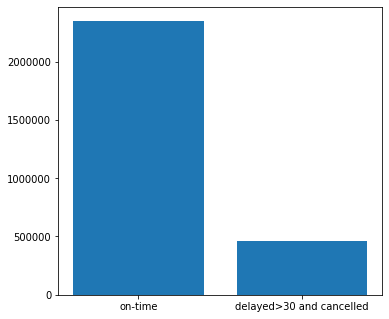

In [57]:
from collections import Counter
class_count = Counter(y)

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,0.75,1])
classes = ['on-time', 'delayed>30 and cancelled']
samples = [class_count[0], class_count[1]]
ax.bar(classes, samples)
plt.show()

In [7]:
emb_cols = ['carrier_code', 'day', 'weekday', 'month', 'origin_airport', 'destination_airport']
simple_cols = ['scheduled_elapsed_time', 'sin_scheduled_departure', 'cos_scheduled_departure', 'sin_scheduled_arrival', 'cos_scheduled_arrival', 
             'HourlyDryBulbTemperature_x', 'HourlyPrecipitation_x', 'HourlyVisibility_x', 'HourlyWindSpeed_x',
             'HourlyDryBulbTemperature_y', 'HourlyPrecipitation_y', 'HourlyVisibility_y', 'HourlyWindSpeed_y']

In [8]:
# prepare embedding inputs
from sklearn.preprocessing import OrdinalEncoder

# prepare input data
def prepare_embedding_inputs(X, emb_cols):
    les = []
    X_emb = np.empty((len(emb_cols), len(X)), dtype='int') 
    for i, column_name in enumerate(emb_cols):
      le = OrdinalEncoder()
      le.fit(X[:, i].reshape(-1, 1))
      enc = le.transform(X[:, i].reshape(-1, 1)).reshape(-1)
      X_emb[i] = enc
      les.append(le)
    return X_emb, les

X_emb, les = prepare_embedding_inputs(X, emb_cols)

In [9]:
# prepare simple inputs
from sklearn.preprocessing import PowerTransformer, MinMaxScaler

# prepare input data
def prepare_simple_inputs(X, simple_cols):
    X_simple = np.empty((len(simple_cols), len(X)))
    simple_dt = df[simple_cols].to_numpy()
    transformer = MinMaxScaler()
    X_simple = transformer.fit_transform(simple_dt)
    return X_simple, transformer

X_simple, ss = prepare_simple_inputs(X, simple_cols)

In [10]:
X_simple_reshaped = X_simple.reshape(len(simple_cols),-1)
X_enc = np.concatenate((X_emb.T, X_simple_reshaped.T), axis=1)

In [11]:
from sklearn.model_selection import train_test_split

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size=0.2, random_state=1, shuffle=True)
# summarize
print('Train', X_train.shape, y_train.shape)
# print('Validation', X_val.shape, y_val.shape)
print('Test', X_test.shape, y_test.shape)

Train (2250365, 19) (2250365,)
Test (562592, 19) (562592,)


In [12]:
from imblearn.combine import SMOTETomek

sm = SMOTETomek(sampling_strategy='minority')

from collections import Counter
counter = Counter(y_train)
print(counter)

def create_class_weight(labels_dict, mu=0.15):
    import math
    total = sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()

    for key in keys:
        score = (1/labels_dict[key]) * (total) / 2.0
        class_weight[key] = score
        
    return class_weight

class_weights = create_class_weight(dict(counter))

X_smotetomek, y_smotetomek = sm.fit_resample(X_train, y_train)

from collections import Counter
counter = Counter(y_smotetomek)
print(counter)

Counter({0: 1881222, 1: 369143})
Counter({0: 1854757, 1: 1854757})


In [13]:
from tensorflow.keras.layers import Input, concatenate, Dense, Dropout
from tensorflow.python.keras.layers import Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal

def build_emb_model():
  # prepare embedding layers
  in_emb_layers = []
  emb_layers = []

  for i, column_name in enumerate(emb_cols):
    n_labels = np.unique(X[:, i]).shape[0]
    print(f'{column_name} - {n_labels}')
    inl = Input(shape=np.shape(1,), name=column_name + '_input')
    in_emb_layers.append(inl)
    emb_dimension = min(n_labels // 2, 50)
    eml = Embedding(input_dim=n_labels, 
                  output_dim=emb_dimension, 
                  name=column_name + '_emb',
                  embeddings_initializer=RandomNormal())(inl)
    emb_layers.append(eml)

  merge_em = concatenate(emb_layers)
  dense = Dense(units=64, activation='relu')(merge_em)
  emb_model = Model(inputs=in_emb_layers, outputs=dense)
  return emb_model

In [14]:
def build_simple_model():
  # prepare simple inputs
  simple_in = Input(shape=(len(simple_cols),), name='simple_input')
  d = Dense(units=26, activation='relu')(simple_in)
  d = Dense(units=24, activation='relu')(d)
  simple_model = Model(inputs=simple_in, outputs=d)
  return simple_model

In [15]:
from tensorflow import keras

METRICS = [keras.metrics.BinaryAccuracy(name='accuracy'),
            keras.metrics.TruePositives(name='tp'),
            keras.metrics.FalsePositives(name='fp'),
            keras.metrics.TrueNegatives(name='tn'),
            keras.metrics.FalseNegatives(name='fn'),
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.AUC(name='auc')]

def build_model(metrics, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  emb_model = build_emb_model()
  simple_model = build_simple_model()
  combined = concatenate([emb_model.output, simple_model.output])
  dense = Dense(48, activation='relu')(combined)
  dense = Dense(80, activation='relu')(dense)
  dense = Dense(80, activation='relu')(dense)
  dense = Dropout(0.15)(dense)
  dense = Dense(64, activation='relu')(dense)
  dense = Dense(32, activation='relu')(dense)
  dense = Dense(16, activation='relu')(dense)
  dense = Dense(8, activation='relu')(dense)
  output = Dense(1, 
                 activation='sigmoid',
                 bias_initializer=output_bias)(dense)
  model = Model(inputs=[emb_model.input, simple_model.input], outputs=output)
 
  optimizer = tf.keras.optimizers.Adam(lr=0.0005060411140993145)
  model.compile(optimizer=optimizer, 
                loss=keras.losses.BinaryCrossentropy(),
                metrics=metrics)
  return model

In [16]:
initial_bias = np.log([class_weights[1]/class_weights[0]])
print(initial_bias)

[1.62849274]


In [17]:
model = build_model(METRICS, output_bias=initial_bias)

carrier_code - 10
day - 31
weekday - 7
month - 4
origin_airport - 363
destination_airport - 363


In [18]:
from tensorflow.keras.callbacks import EarlyStopping
monitor = EarlyStopping(monitor='val_auc', min_delta=1e-3, patience=4, 
                        verbose=1, mode='auto', restore_best_weights=True)
history = model.fit([X_smotetomek[:, i] for i in range(6)] + [X_smotetomek[:, 6:]], 
          y_smotetomek,
          validation_data=([X_test[:, i] for i in range(6)] + [X_test[:, 6:]], y_test),
          epochs=10, 
          verbose=2,
          callbacks=[monitor],
          class_weight=class_weights,
          batch_size=32)

Epoch 1/10
115923/115923 - 457s - loss: 0.4942 - accuracy: 0.6930 - tp: 1759644.0000 - fp: 1043698.0000 - tn: 811059.0000 - fn: 95113.0000 - precision: 0.6277 - recall: 0.9487 - auc: 0.9035 - val_loss: 0.8120 - val_accuracy: 0.5451 - val_tp: 71237.0000 - val_fp: 235431.0000 - val_tn: 235415.0000 - val_fn: 20509.0000 - val_precision: 0.2323 - val_recall: 0.7765 - val_auc: 0.7087
Epoch 2/10
115923/115923 - 459s - loss: 0.4452 - accuracy: 0.7475 - tp: 1739188.0000 - fp: 821007.0000 - tn: 1033750.0000 - fn: 115569.0000 - precision: 0.6793 - recall: 0.9377 - auc: 0.9237 - val_loss: 0.7607 - val_accuracy: 0.5845 - val_tp: 68829.0000 - val_fp: 210855.0000 - val_tn: 259991.0000 - val_fn: 22917.0000 - val_precision: 0.2461 - val_recall: 0.7502 - val_auc: 0.7191
Epoch 3/10
115923/115923 - 459s - loss: 0.4348 - accuracy: 0.7560 - tp: 1740390.0000 - fp: 790929.0000 - tn: 1063828.0000 - fn: 114367.0000 - precision: 0.6875 - recall: 0.9383 - auc: 0.9277 - val_loss: 0.7041 - val_accuracy: 0.6383 - va

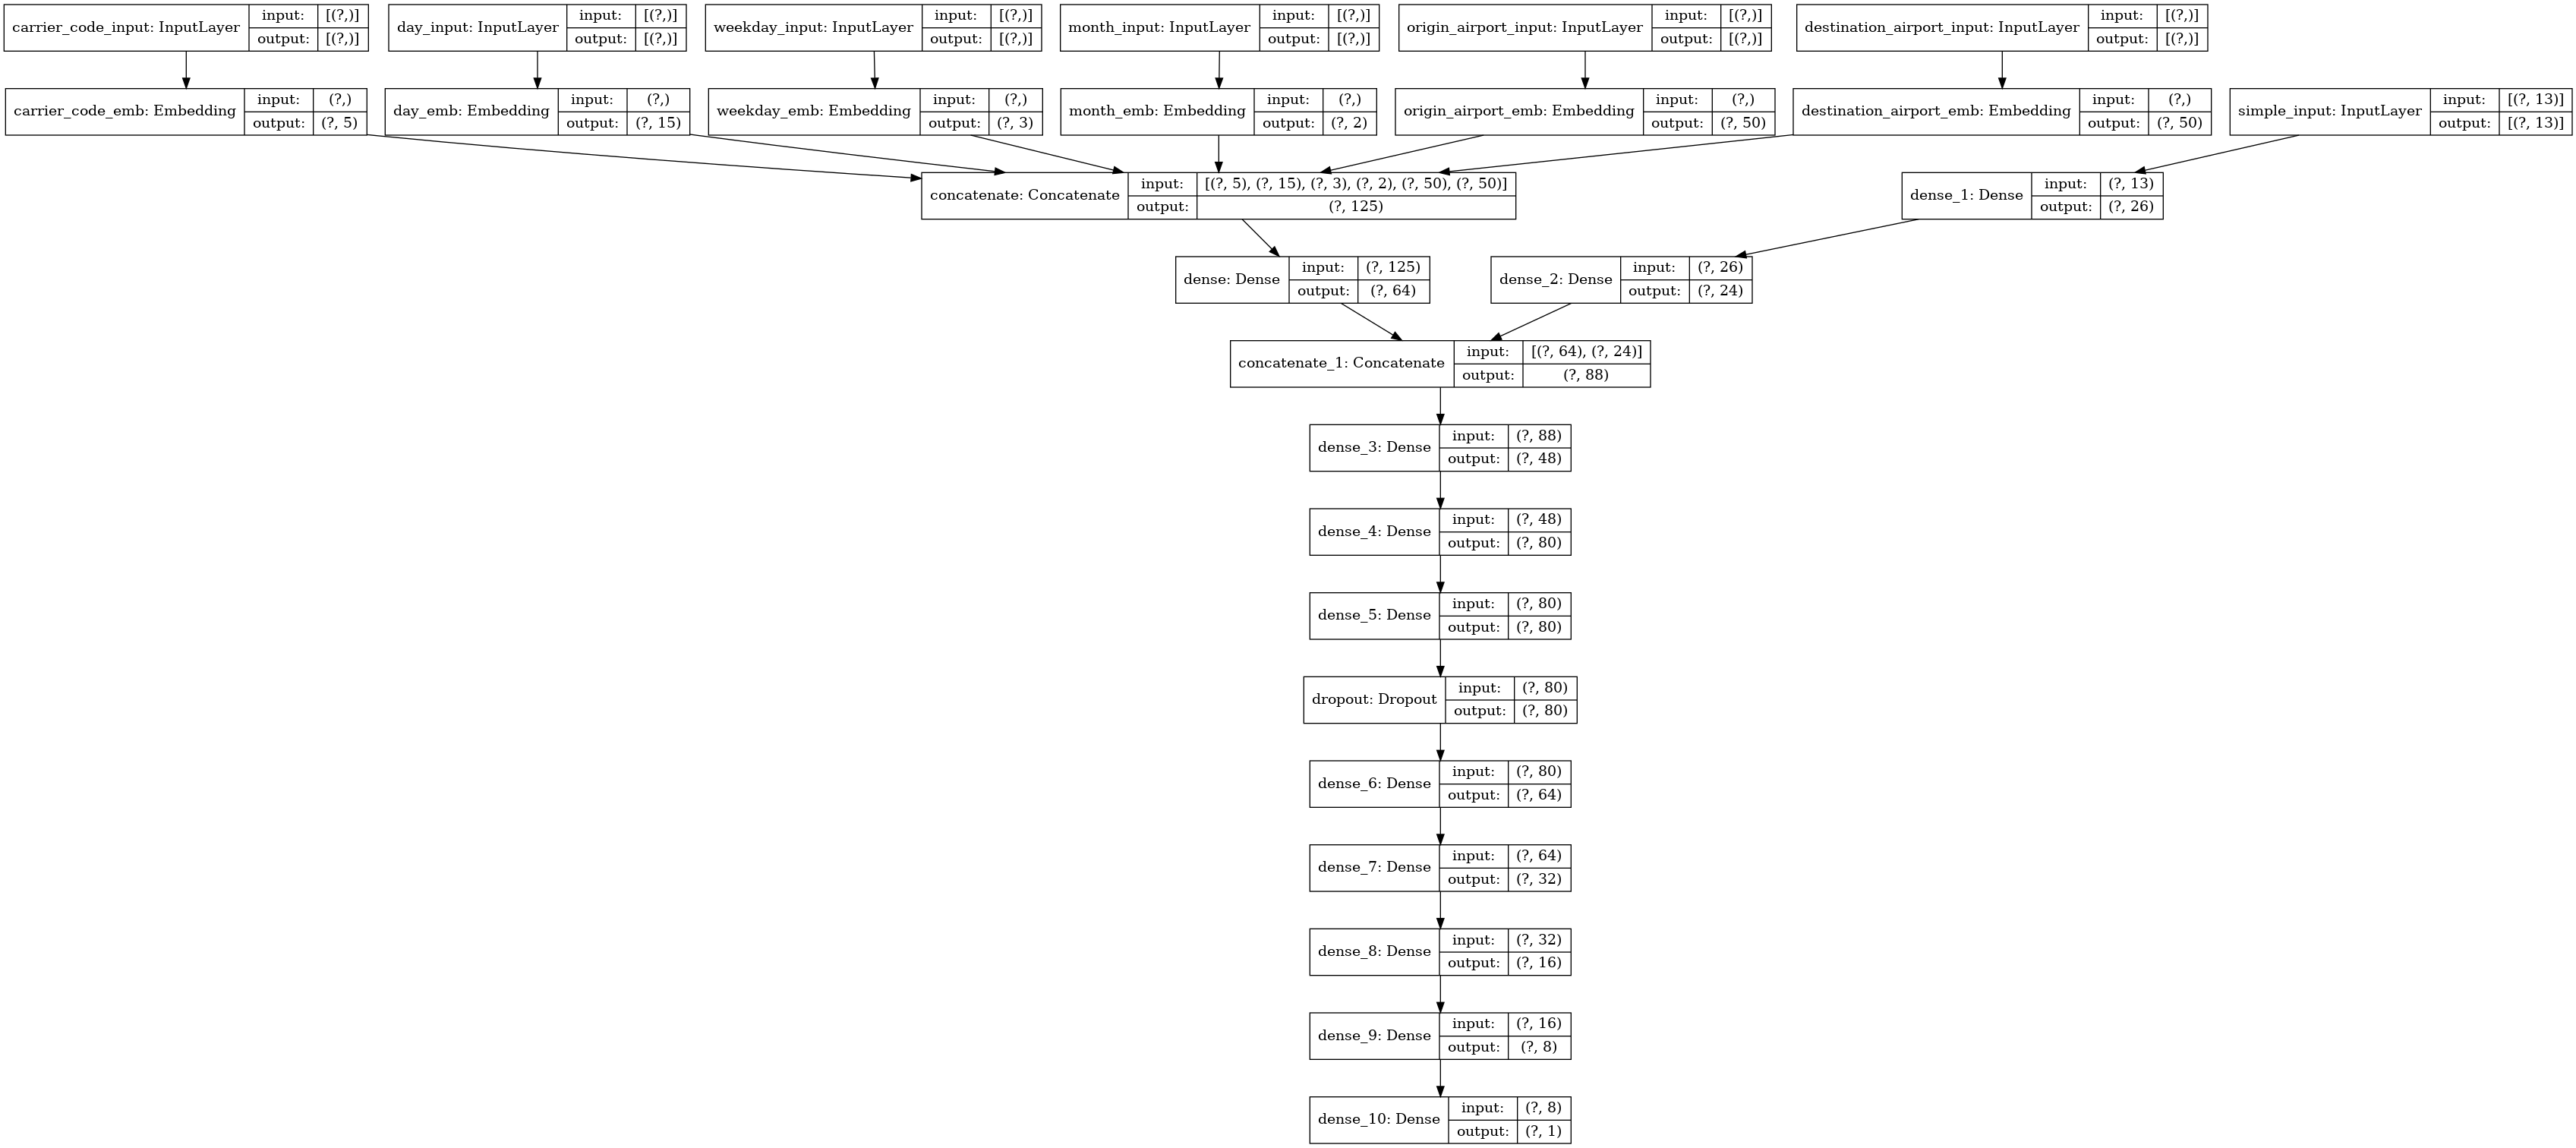

In [35]:
# save model plot
from tensorflow.keras.utils import  plot_model
plot_model(model, to_file='model.png', show_shapes=True)

In [19]:
# serialize model to JSON
model_json = model.to_json()
with open("model_10_06_12_00.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_10_06_12_00.h5")

In [21]:
# evaluate the keras model
loss, acc, tp, fp, tn, fn, precision, recall, auc = model.evaluate([X_test[:, i] for i in range(6)] + [X_test[:, 6:]], y_test, verbose=0)
print(f'Accuracy: {acc*100}')
print(f'TP: {tp}; FP: {fp}; TN: {tn}; FN: {fn}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'AUC: {auc}')

Accuracy: 54.50699329376221
TP: 71237.0; FP: 235431.0; TN: 235415.0; FN: 20509.0
Precision: 0.23229356110095978
Recall: 0.7764589190483093
AUC: 0.7086983323097229


In [22]:
predictions = model.predict([X_test[:, i] for i in range(6)] + [X_test[:, 6:]])
preds = predictions>0.5

In [26]:
from sklearn.metrics import roc_auc_score
roc_auc_score = roc_auc_score(y_test, preds)
print(roc_auc_score)

0.6382209642482949


/home/dan/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


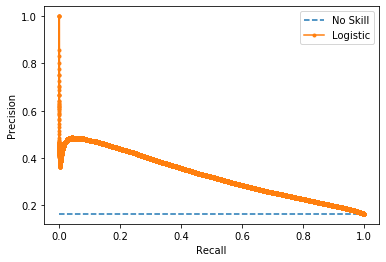

In [27]:
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_test, predictions)

from matplotlib import pyplot
no_skill = len(y[y==1]) / len(y)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, marker='.', label='Logistic')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
pyplot.show()

In [28]:
from sklearn.metrics import auc
auc_score = auc(recall, precision)
print(auc_score)

0.32651421644593653


0.501310242426051
0.7087050363372518


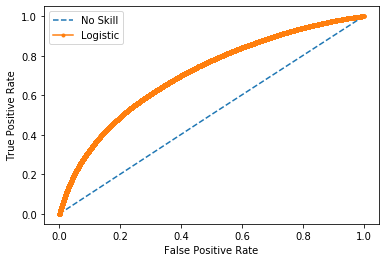

In [29]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score, roc_curve

# plot no skill and model roc curves
def plot_roc_curve(test_y, naive_probs, model_probs):
	# plot naive skill roc curve
	fpr, tpr, _ = roc_curve(test_y, naive_probs)
	pyplot.plot(fpr, tpr, linestyle='--', label='No Skill')
	# plot model roc curve
	fpr, tpr, _ = roc_curve(test_y, model_probs)
	pyplot.plot(fpr, tpr, marker='.', label='Logistic')
	# axis labels
	pyplot.xlabel('False Positive Rate')
	pyplot.ylabel('True Positive Rate')
	# show the legend
	pyplot.legend()
	# show the plot
	pyplot.show()
    
dummy_model = DummyClassifier(strategy='stratified')
dummy_model.fit(X_smotetomek, y_smotetomek)
y_dummy = dummy_model.predict_proba(X_test)
probs_dummy = y_dummy[:, 1]
roc_auc_dummy = roc_auc_score(y_test, probs_dummy)
print(roc_auc_dummy)

roc_auc = roc_auc_score(y_test, predictions)
print(roc_auc)
plot_roc_curve(y_test, probs_dummy, predictions)

In [34]:
class_weights

{0: 0.5981125566254275, 1: 1.5240469140685315}

In [35]:
Counter(y_test)

Counter({0: 470846, 1: 91746})

In [36]:
class_weights[1] *= 2
class_weights

{0: 0.5981125566254275, 1: 3.048093828137063}

In [37]:
from tensorflow.keras.callbacks import EarlyStopping
monitor = EarlyStopping(monitor='val_auc', min_delta=1e-3, patience=3, 
                        verbose=1, mode='auto', restore_best_weights=True)
history = model.fit([X_smotetomek[:, i] for i in range(6)] + [X_smotetomek[:, 6:]], 
          y_smotetomek,
          validation_data=([X_test[:, i] for i in range(6)] + [X_test[:, 6:]], y_test),
          epochs=12, 
          initial_epoch=10,
          verbose=2,
          callbacks=[monitor],
          class_weight=class_weights,
          batch_size=32)

Epoch 11/12
115923/115923 - 464s - loss: 0.4234 - accuracy: 0.7718 - tp: 1737126.0000 - fp: 728727.0000 - tn: 1126030.0000 - fn: 117631.0000 - precision: 0.7045 - recall: 0.9366 - auc: 0.9322 - val_loss: 0.6689 - val_accuracy: 0.6807 - val_tp: 59909.0000 - val_fp: 147796.0000 - val_tn: 323050.0000 - val_fn: 31837.0000 - val_precision: 0.2884 - val_recall: 0.6530 - val_auc: 0.7280
Epoch 12/12


KeyboardInterrupt: 

In [38]:
# evaluate the keras model
loss, acc, tp, fp, tn, fn, precision, recall, auc = model.evaluate([X_test[:, i] for i in range(6)] + [X_test[:, 6:]], y_test, verbose=0)
print(f'Accuracy: {acc*100}')
print(f'TP: {tp}; FP: {fp}; TN: {tn}; FN: {fn}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'AUC: {auc}')

Accuracy: 67.92755722999573
TP: 60013.0; FP: 148704.0; TN: 322142.0; FN: 31733.0
Precision: 0.28753286600112915
Recall: 0.6541211605072021
AUC: 0.7282673716545105


In [39]:
predictions = model.predict([X_test[:, i] for i in range(6)] + [X_test[:, 6:]])
preds = predictions>0.5

In [40]:
from sklearn.metrics import roc_auc_score
roc_auc_score = roc_auc_score(y_test, preds)
print(roc_auc_score)

0.6691490763240802


/home/dan/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


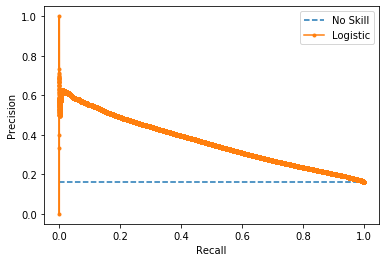

In [41]:
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_test, predictions)

from matplotlib import pyplot
no_skill = len(y[y==1]) / len(y)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, marker='.', label='Logistic')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
pyplot.show()

0.5012749600603401
0.7282868099575159


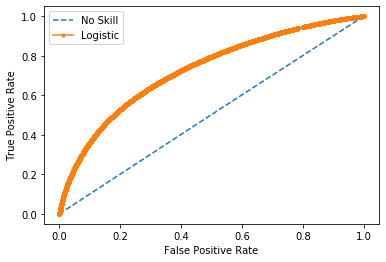

In [42]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score, roc_curve

# plot no skill and model roc curves
def plot_roc_curve(test_y, naive_probs, model_probs):
	# plot naive skill roc curve
	fpr, tpr, _ = roc_curve(test_y, naive_probs)
	pyplot.plot(fpr, tpr, linestyle='--', label='No Skill')
	# plot model roc curve
	fpr, tpr, _ = roc_curve(test_y, model_probs)
	pyplot.plot(fpr, tpr, marker='.', label='Logistic')
	# axis labels
	pyplot.xlabel('False Positive Rate')
	pyplot.ylabel('True Positive Rate')
	# show the legend
	pyplot.legend()
	# show the plot
	pyplot.show()
    
dummy_model = DummyClassifier(strategy='stratified')
dummy_model.fit(X_smotetomek, y_smotetomek)
y_dummy = dummy_model.predict_proba(X_test)
probs_dummy = y_dummy[:, 1]
roc_auc_dummy = roc_auc_score(y_test, probs_dummy)
print(roc_auc_dummy)

roc_auc = roc_auc_score(y_test, predictions)
print(roc_auc)
plot_roc_curve(y_test, probs_dummy, predictions)

In [43]:
from tensorflow.keras.callbacks import EarlyStopping
monitor = EarlyStopping(monitor='val_auc', min_delta=1e-3, patience=3, 
                        verbose=1, mode='auto', restore_best_weights=True)
history = model.fit([X_smotetomek[:, i] for i in range(6)] + [X_smotetomek[:, 6:]], 
          y_smotetomek,
          validation_data=([X_test[:, i] for i in range(6)] + [X_test[:, 6:]], y_test),
          epochs=12, 
          initial_epoch=11,
          verbose=2,
          callbacks=[monitor],
          class_weight=class_weights,
          batch_size=32)

Epoch 12/12
115923/115923 - 485s - loss: 0.4215 - accuracy: 0.7741 - tp: 1737716.0000 - fp: 721041.0000 - tn: 1133716.0000 - fn: 117041.0000 - precision: 0.7067 - recall: 0.9369 - auc: 0.9329 - val_loss: 0.7430 - val_accuracy: 0.5916 - val_tp: 69183.0000 - val_fp: 207222.0000 - val_tn: 263624.0000 - val_fn: 22563.0000 - val_precision: 0.2503 - val_recall: 0.7541 - val_auc: 0.7267


In [44]:
predictions = model.predict([X_test[:, i] for i in range(6)] + [X_test[:, 6:]])
preds = predictions>0.5

In [45]:
# evaluate the keras model
loss, acc, tp, fp, tn, fn, precision, recall, auc = model.evaluate([X_test[:, i] for i in range(6)] + [X_test[:, 6:]], y_test, verbose=0)
print(f'Accuracy: {acc*100}')
print(f'TP: {tp}; FP: {fp}; TN: {tn}; FN: {fn}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'AUC: {auc}')

Accuracy: 59.156012535095215
TP: 69183.0; FP: 207222.0; TN: 263624.0; FN: 22563.0
Precision: 0.2502957582473755
Recall: 0.7540709972381592
AUC: 0.726661205291748


In [46]:
from sklearn.metrics import roc_auc_score
roc_auc_score = roc_auc_score(y_test, preds)
print(roc_auc_score)

0.6569826700286405


0.5007593898545423
0.7266621048726409


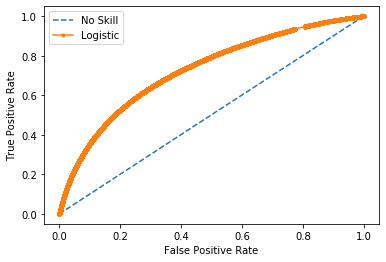

In [47]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score, roc_curve

# plot no skill and model roc curves
def plot_roc_curve(test_y, naive_probs, model_probs):
	# plot naive skill roc curve
	fpr, tpr, _ = roc_curve(test_y, naive_probs)
	pyplot.plot(fpr, tpr, linestyle='--', label='No Skill')
	# plot model roc curve
	fpr, tpr, _ = roc_curve(test_y, model_probs)
	pyplot.plot(fpr, tpr, marker='.', label='Logistic')
	# axis labels
	pyplot.xlabel('False Positive Rate')
	pyplot.ylabel('True Positive Rate')
	# show the legend
	pyplot.legend()
	# show the plot
	pyplot.show()
    
dummy_model = DummyClassifier(strategy='stratified')
dummy_model.fit(X_smotetomek, y_smotetomek)
y_dummy = dummy_model.predict_proba(X_test)
probs_dummy = y_dummy[:, 1]
roc_auc_dummy = roc_auc_score(y_test, probs_dummy)
print(roc_auc_dummy)

roc_auc = roc_auc_score(y_test, predictions)
print(roc_auc)
plot_roc_curve(y_test, probs_dummy, predictions)

/home/dan/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


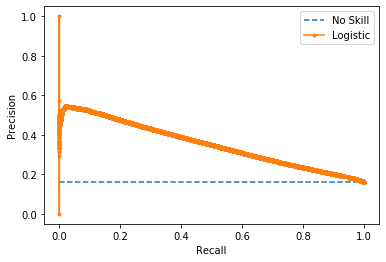

In [48]:
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_test, predictions)

from matplotlib import pyplot
no_skill = len(y[y==1]) / len(y)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, marker='.', label='Logistic')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
pyplot.show()

In [49]:
con_mat = confusion_matrix(y_test, preds)
print(con_mat)

[[263624 207222]
 [ 22563  69183]]
